In [2]:
!pip install networkx 

In [3]:
import networkx as nx

In [4]:
import matplotlib.pyplot as plt

In /home/kaypee/miniconda3/envs/fastweb/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kaypee/miniconda3/envs/fastweb/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kaypee/miniconda3/envs/fastweb/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kaypee/miniconda3/envs/fastweb/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

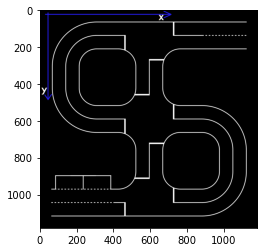

In [41]:
G = nx.read_graphml('test_track.graphml')
import cv2
img=cv2.imread("Track_Test_coord.png")
plt.imshow(img)

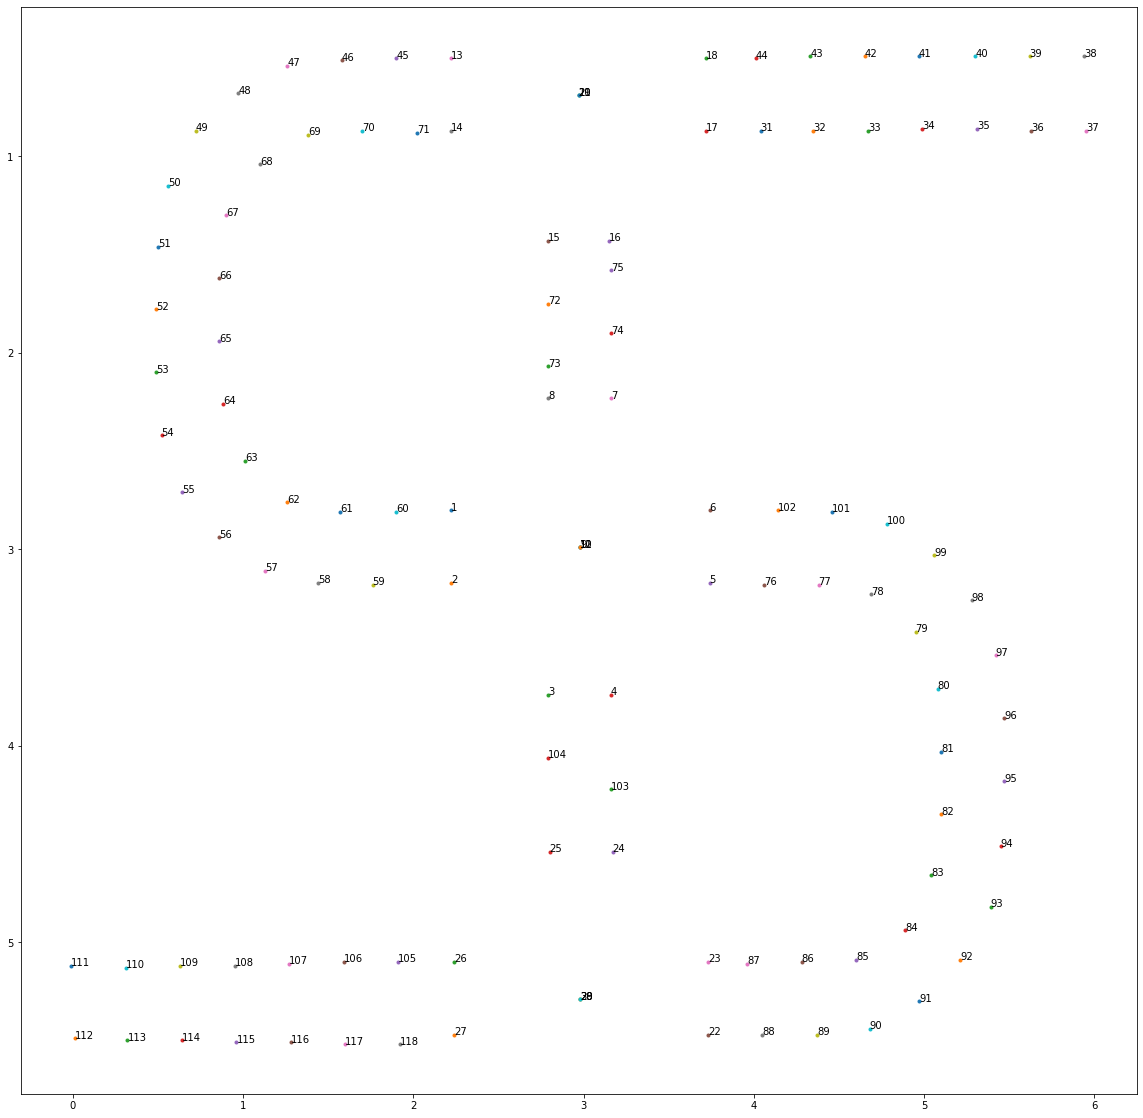

In [40]:
plt.figure(figsize=(20,20))
for node,data in G.nodes(data=True):
    plt.plot(data['x'],data['y'],'.')
    ax = plt.gca()
    ax.annotate(str(node), (data['x'],data['y'])) 

ax = plt.gca()
ax.invert_yaxis()
# plt.legend()
# plt.show()

In [508]:
for i in G.neighbors('24'):
    print(i)

103


In [509]:
import heapq
def dijkstra(G, start, target):
    d = {start: 0}
    parent = {start: None}
    pq = [(0, start)]
    visited = set()
    while pq:
        du, u = heapq.heappop(pq)
        if u in visited:
            continue
        if u == target:
            break
        visited.add(u)
        for v  in G.adj[u]:
            if v not in d or d[v] > du + 1:
                d[v] = du + 1
                parent[v] = u
                heapq.heappush(pq, (d[v], v))

    fp = [target]
    tg = target

    while tg != start:
        fp.insert(0, parent[tg])
        tg = parent[tg]

    return fp

In [581]:
path_list=dijkstra(G,'112','35')

In [582]:
G["112"]

AtlasView({'113': {'dotted': False}})

In [583]:
node_dict=G.nodes(data=True)

In [584]:
node_dict['112']

{'x': 0.01, 'y': 5.49}

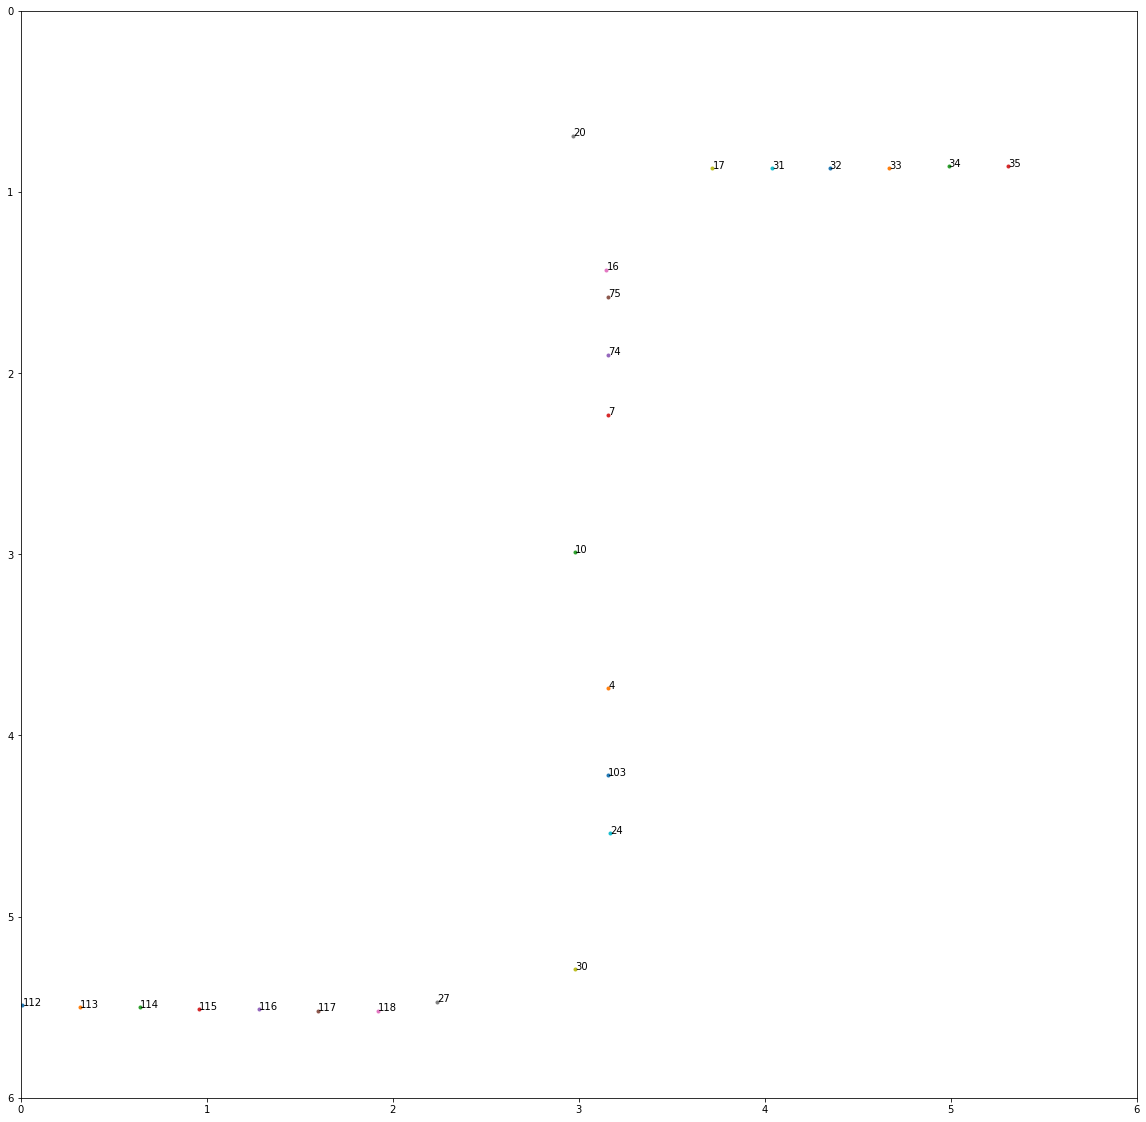

In [585]:
coord_list=[]
plt.figure(figsize=(20,20))
for i in path_list:
    data=node_dict[i]
    plt.plot(data['x'],data['y'],'.')
    coord_list.append((data['x'],data['y']))
    ax = plt.gca()
    ax.annotate(str(i), (data['x'],data['y'])) 

plt.xlim(0,6)
plt.ylim(0,6)


ax = plt.gca()
ax.invert_yaxis()

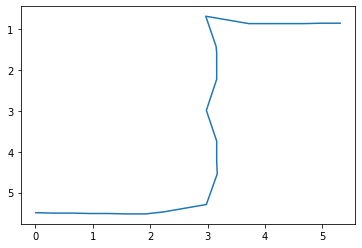

In [586]:
x, y = zip(*coord_list)
plt.plot(x,y)
ax = plt.gca()
ax.invert_yaxis()

In [587]:
## Global polyfit doesnt work as expected

In [588]:
import numpy as np
z = np.polyfit(x, y, 6)
p=np.poly1d(z)

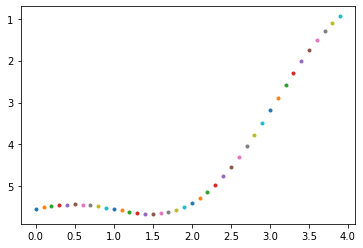

In [589]:
xp=[]
yp=[]
for xx in range(0,40):
    num=xx/10
    xp.append(num)
    yy=p(num)
    yp.append(yy)
    plt.plot(num,yy,'.')
ax = plt.gca()
ax.invert_yaxis()

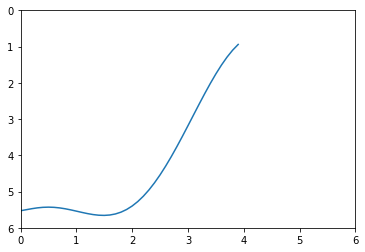

In [590]:
plt.plot(xp,yp)
plt.xlim(0,6)
plt.ylim(0,6)


ax = plt.gca()
ax.invert_yaxis()

In [591]:
# local poly fitting for adjacent node
print(len(path_list))

24


In [592]:
import math
coord_list=[]
window_size=6
# plt.figure(figsize=(20,20))
print(len(path_list))
for i in range(0,len(path_list),window_size):
    print(i)
    cx,cy=[],[]
    try:
        for j in range(0,window_size+6):
            cx.append(node_dict[path_list[i+j]]['x'])
            cy.append(node_dict[path_list[i+j]]['y'])
        z=np.polyfit(cx,cy,3)
        p=np.poly1d(z)
        cxl=np.arange(cx[0],cx[-6],0.001)
        for i in cxl:
            coord_list.append((i,p(i)))
    except:    
        for j in range(0-6,window_size):
            cx.append(node_dict[path_list[i+j]]['x'])
            cy.append(node_dict[path_list[i+j]]['y'])
        z=np.polyfit(cx,cy,3)
        p=np.poly1d(z)
        cxl=np.arange(cx[6+1],cx[-1],0.05)
        for i in cxl:
            coord_list.append((i,p(i)))

        


24
0
6
12
18


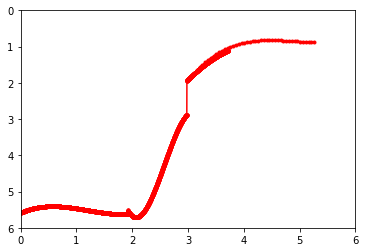

In [593]:
x, y = zip(*coord_list)
plt.plot(x,y,c='r',marker=".")
plt.xlim(0,6)
plt.ylim(0,6)
ax = plt.gca()
ax.invert_yaxis()


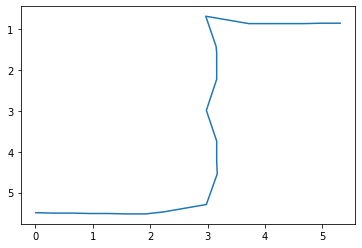

In [594]:
coord_list=[]
for i in path_list:
    data=node_dict[i]
#     plt.plot(data['x'],data['y'],'.')
    coord_list.append((data['x'],data['y']))
#     ax = plt.gca()
#     ax.annotate(str(i), (data['x'],data['y'])) 
x,y=zip(*coord_list)
plt.plot(x,y)
ax = plt.gca()
ax.invert_yaxis()
# plt.xlim(0,6)
# plt.ylim(0,6)


# ax = plt.gca()
# ax.invert_yaxis()

In [595]:
zz=np.polyfit(x,y,18)

/home/kaypee/miniconda3/envs/fastweb/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [596]:
pp=np.poly1d(zz)

In [597]:
xxx=np.arange(0,5,0.01)

In [598]:
yyy=[]
for i in xxx:
    yyy.append(pp(i))

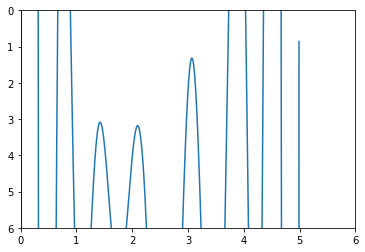

In [599]:
plt.plot(xxx,yyy)
plt.xlim(0,6)
plt.ylim(0,6)
ax = plt.gca()
ax.invert_yaxis()

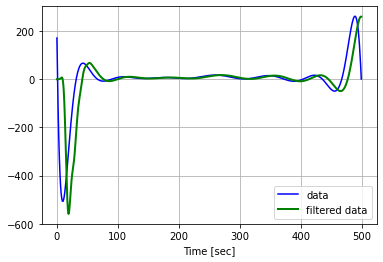

In [600]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 10
fs = 10000.0       # sample rate, Hz
cutoff = 1000  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
# w, h = freqz(b, a, worN=8000)
# plt.subplot(2, 1, 1)
# plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
# plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
# plt.axvline(cutoff, color='k')
# plt.xlim(0, 0.5*fs)
# plt.title("Lowpass Filter Frequency Response")
# plt.xlabel('Frequency [Hz]')
# plt.grid()


# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 1.5         # seconds
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = yyy

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

# plt.subplot(2, 1, 2)
plt.plot( data, 'b-', label='data')
plt.plot( y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()